<a href="https://colab.research.google.com/github/DHjeelm/OpenProjectAboutGANs/blob/main/Wasserstein_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import tensorflow as tf
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

In [2]:
# Class that clips the model weights
class ClipConstraint(Constraint):

  # Set clip value when initialized
  def __init__(self, clip_value):
    self.clip_value = clip_value

  # Clip model weights to hypercube
  def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)

  # Get the config
  def get_config(self):
    return {'Clip_value': self.clip_value}

In [3]:
# Function that calculates Wasserstein loss
def wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true * y_pred)

In [4]:
# Define Critic
def define_critic(in_shape=(28,28,1)):

  # Weight initialization and constraint
  init = RandomNormal(stddev=0.02)
  const = ClipConstraint(0.01)

  # Define model
  model = Sequential()

  # Model architechture
  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init,
  kernel_constraint=const, input_shape=in_shape))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init,
  kernel_constraint=const))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(1))

  # Define optimizer and compile model
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  
  return model

In [5]:
# Define Generator
def define_generator(latent_dim):

  # Weight initialization
  init = RandomNormal(stddev=0.02)

  # Define model
  model = Sequential()

  # Model architechture
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',
  kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',
  kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))

  return model

In [6]:
# Define GAN
def define_gan(generator, critic):
  # Make weights in the critic not trainable
  critic.trainable = False
  
  # Create GAN
  model = Sequential()
  model.add(generator)
  model.add(critic)

  # Compile GAN
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  
  return model

In [7]:
# Load real images
def load_real_samples():

  # Load dataset
  (trainX, trainy), (_, _) = load_data()

  # Select all of the examples for a given class
  selected_ix = trainy == 7
  X = trainX[selected_ix]

  # Expand to 3d
  X = expand_dims(X, axis=-1)

  # Convert from ints to floats
  X = X.astype('float32')

  # Scale to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [8]:
# Generate real samples
def generate_real_samples(dataset, n_samples):

  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]

  # Class label = -1 for real
  y = -ones((n_samples, 1))
  return X, y

In [9]:
# Generate inputs to generator
def generate_latent_points(latent_dim, n_samples):

  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  
  return x_input

In [10]:
# Generate fake samples with Generatpr
def generate_fake_samples(generator, latent_dim, n_samples):

  x_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(x_input)
  
  # Class label = 1 for fake
  y = ones((n_samples, 1))
  return X, y

In [11]:
# Performance summary
def summarize_performance(step, g_model, latent_dim, n_samples=100):

  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)

  # Scale to [0,1]
  X = (X + 1) / 2.0

  # Plot images
  for i in range(10 * 10):
    pyplot.subplot(10, 10, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')

  # Save plot
  filename1 = 'generated_plot_%04d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()

  # Save the generator
  filename2 = 'model_%04d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [12]:
# Plot loss
def plot_history(d1_hist, d2_hist, g_hist):
  pyplot.plot(d1_hist, label='crit_real')
  pyplot.plot(d2_hist, label='crit_fake')
  pyplot.plot(g_hist, label='gen')
  pyplot.legend()
  pyplot.savefig('plot_line_plot_loss.png')
  pyplot.close()

In [13]:
# Training
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64,
n_critic=5):
  # Batch and iteration calculations
  bat_per_epo = int(dataset.shape[0] / n_batch)
  n_steps = bat_per_epo * n_epochs
  half_batch = int(n_batch / 2)

  # List for losses
  c1_hist, c2_hist, g_hist = list(), list(), list()

  # Iterate over epochs
  for i in range(n_steps):

    # Update the critic more than the generator
    c1_tmp, c2_tmp = list(), list()
  
    for _ in range(n_critic):
      # Real samples
      X_real, y_real = generate_real_samples(dataset, half_batch)

      # Update critic
      c_loss1 = c_model.train_on_batch(X_real, y_real)
      c1_tmp.append(c_loss1)

      # Fake samples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      # Update critic
      c_loss2 = c_model.train_on_batch(X_fake, y_fake)
      c2_tmp.append(c_loss2)

    # Store the loss
    c1_hist.append(mean(c1_tmp))
    c2_hist.append(mean(c2_tmp))

    # Generate points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)

    # Creaate inverted labels for the fake samples
    y_gan = -ones((n_batch, 1))

    # Critic loss updates the generator
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    g_hist.append(g_loss)

    # Summarize loss on current batch
    print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))

    # Evaluate the model performance every epoch
    if (i+1) % bat_per_epo == 0:
      summarize_performance(i, g_model, latent_dim)

  # Line plots of loss
  plot_history(c1_hist, c2_hist, g_hist)

In [14]:
# Define dimensions and load images
latent_dim = 50
dataset = load_real_samples()

# Create GAN
critic = define_critic()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, critic)

# Train GAN
train(generator, critic, gan_model, dataset, latent_dim)

>1, c1=-2.838, c2=0.066 g=-0.004
>2, c1=-7.504, c2=0.132 g=-0.015
>3, c1=-10.888, c2=0.199 g=-0.025
>4, c1=-13.140, c2=0.255 g=-0.037
>5, c1=-15.312, c2=0.318 g=-0.049
>6, c1=-17.419, c2=0.342 g=-0.062
>7, c1=-18.523, c2=0.371 g=-0.076
>8, c1=-20.604, c2=0.400 g=-0.090
>9, c1=-21.252, c2=0.420 g=-0.110
>10, c1=-22.643, c2=0.477 g=-0.133
>11, c1=-23.824, c2=0.522 g=-0.162
>12, c1=-24.614, c2=0.586 g=-0.193
>13, c1=-25.610, c2=0.688 g=-0.228
>14, c1=-26.146, c2=0.688 g=-0.264
>15, c1=-26.924, c2=0.708 g=-0.311
>16, c1=-27.466, c2=0.735 g=-0.359
>17, c1=-27.773, c2=0.687 g=-0.414
>18, c1=-28.103, c2=0.632 g=-0.479
>19, c1=-28.597, c2=0.518 g=-0.533
>20, c1=-29.276, c2=0.319 g=-0.609
>21, c1=-30.096, c2=0.093 g=-0.674
>22, c1=-30.763, c2=-0.245 g=-0.762
>23, c1=-31.154, c2=-0.613 g=-0.871
>24, c1=-31.136, c2=-1.086 g=-0.986
>25, c1=-31.653, c2=-1.568 g=-1.102
>26, c1=-32.782, c2=-2.249 g=-1.237
>27, c1=-33.389, c2=-2.935 g=-1.367
>28, c1=-33.327, c2=-3.761 g=-1.557
>29, c1=-34.504, c2=-4.5

In [15]:
# Plot generated images
def plot_generated(examples, n):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()

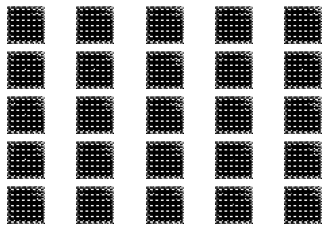

In [16]:
# Load model
from keras.models import load_model
model = load_model('model_0970.h5')

# Generate points for generator
latent_points = generate_latent_points(50, 25)
X = model.predict(latent_points)

# Plot the result
plot_generated(X, 5)